<a href="https://colab.research.google.com/github/zoya-iftekhar/Traffic-Sign-Classification/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Traffic Sign Recognition**

### Importing Dataset

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:26<00:00, 28.3MB/s]
100% 612M/612M [00:26<00:00, 24.3MB/s]


In [4]:
from zipfile import ZipFile
dataset = '/content/gtsrb-german-traffic-sign.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


### Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
train_path = '/content/Train'
test_path = '/content/Test'
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [9]:
num_categories = len(os.listdir(train_path))
num_categories

43

In [10]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'
}

### Visualizing random images from test data

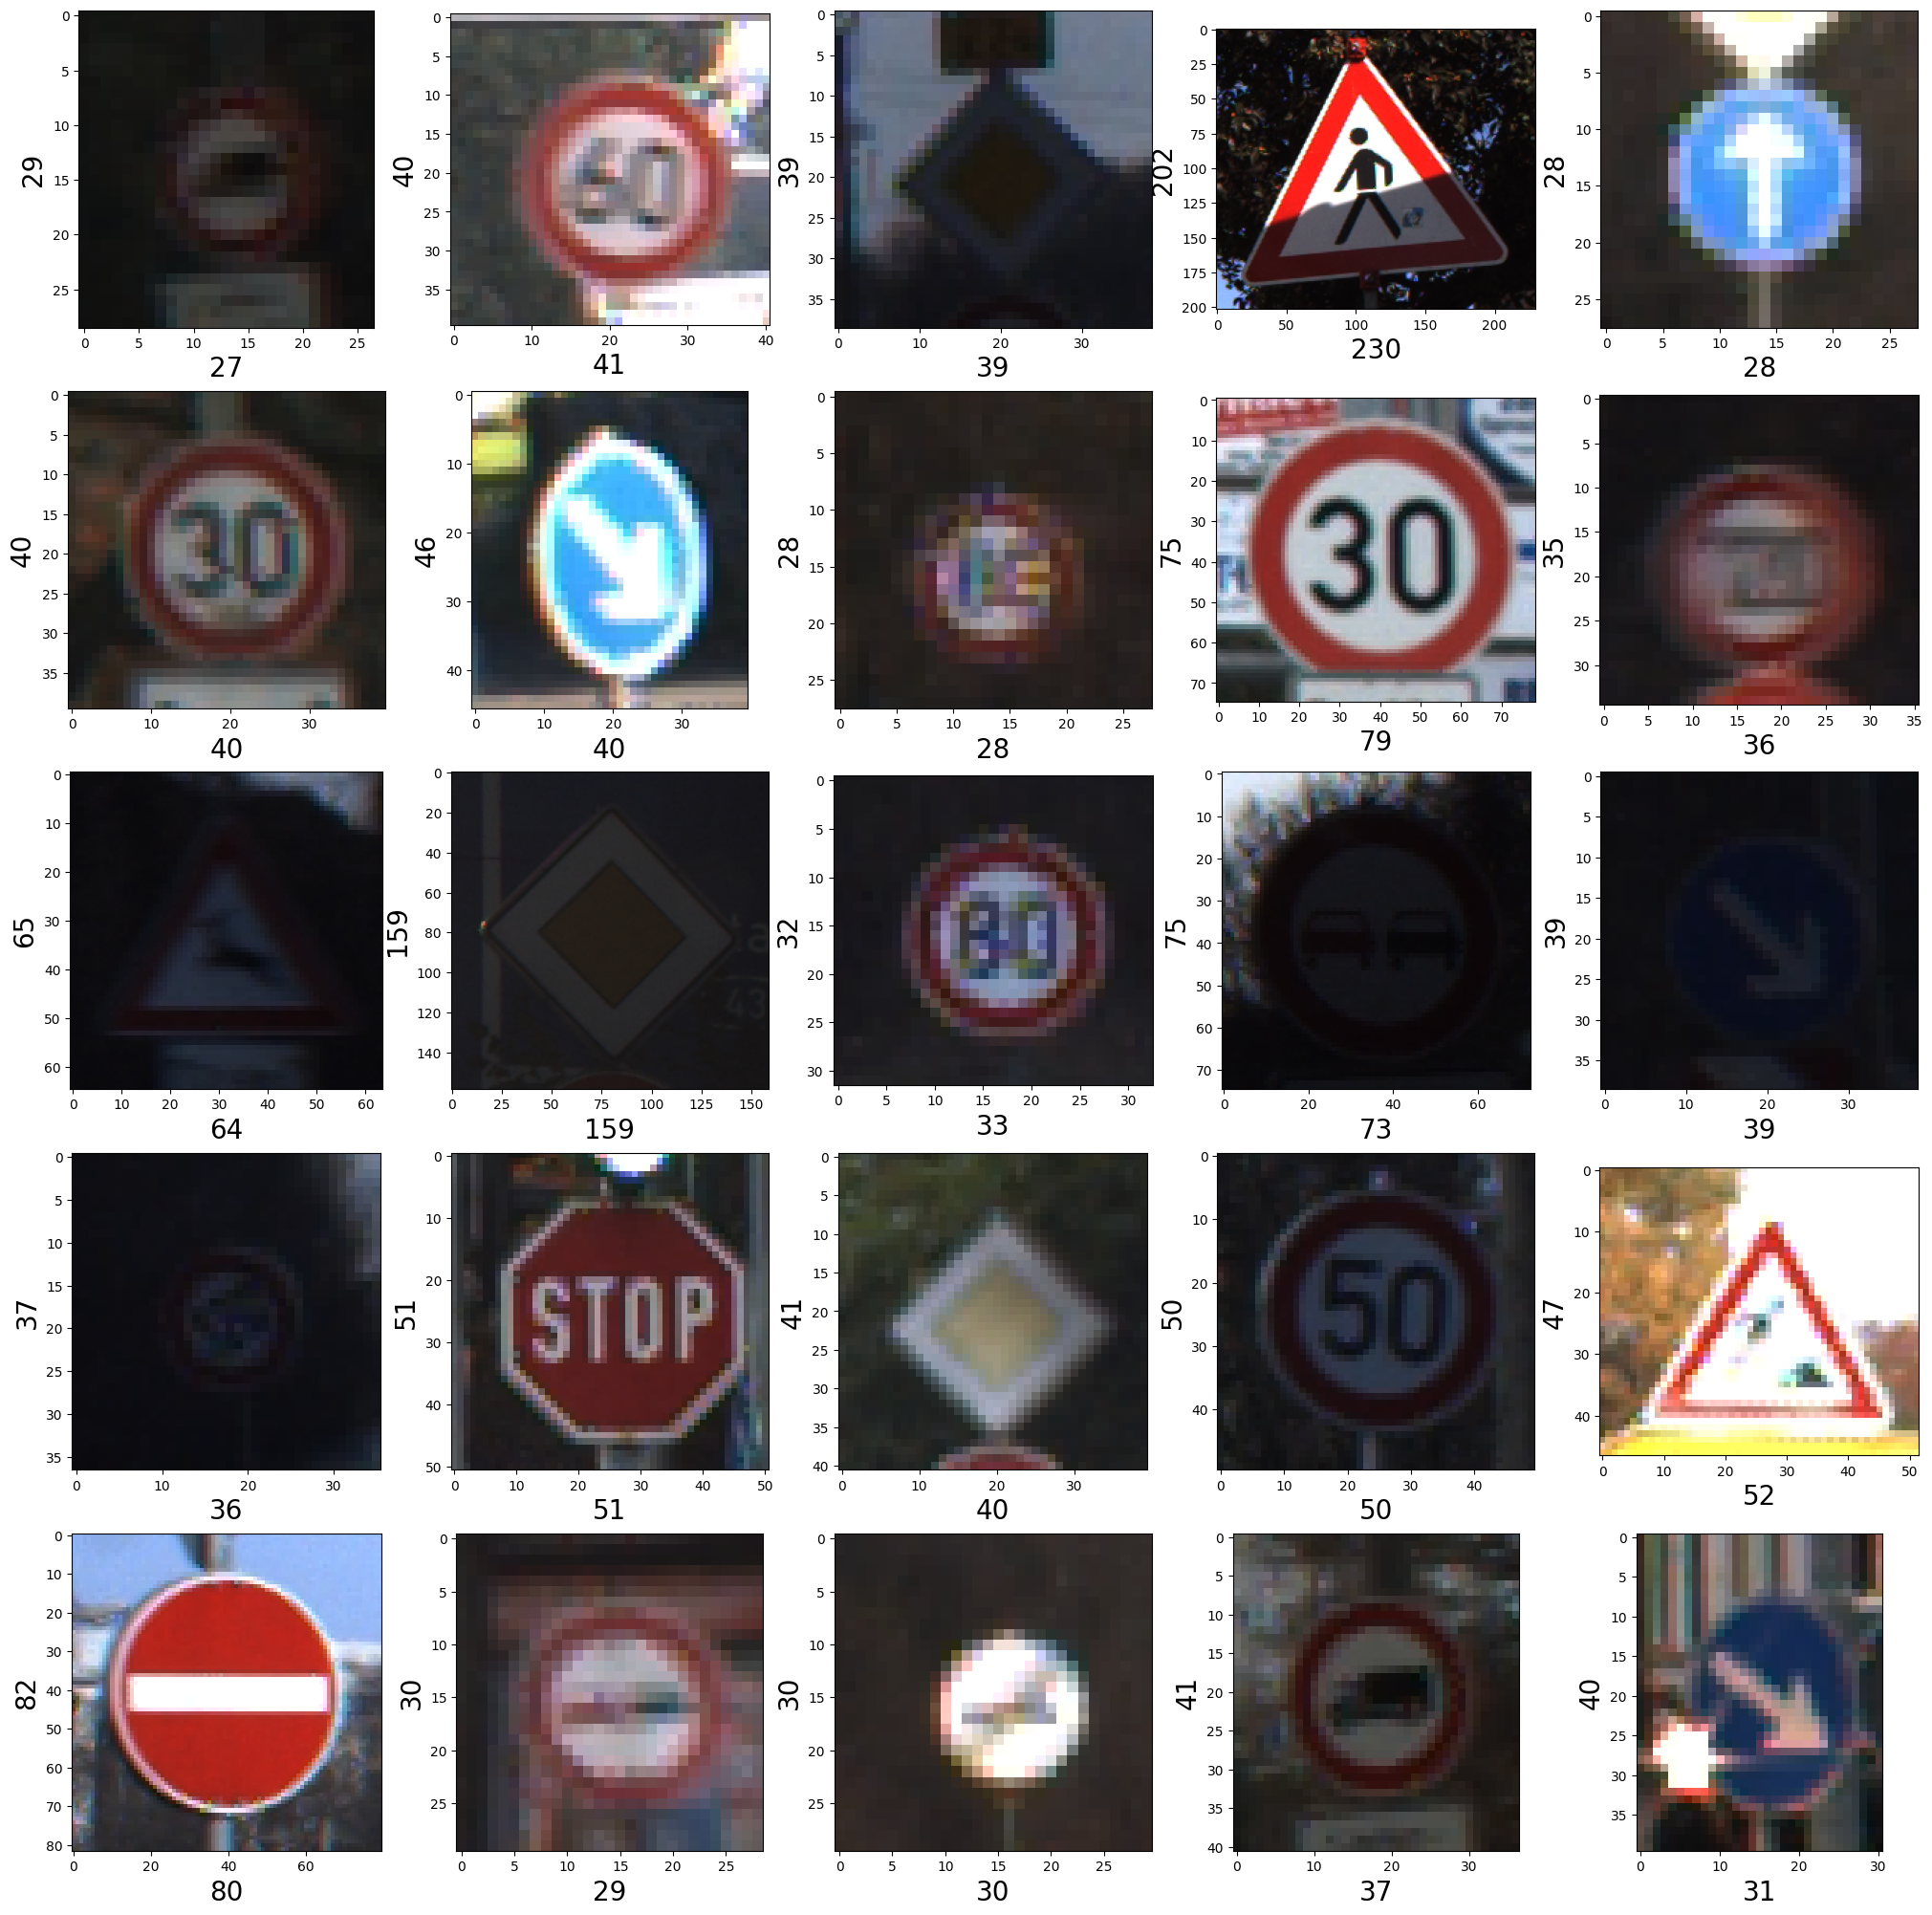

In [13]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('/content/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path =  random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

### Collecting Training Data

In [14]:
image_data = []
image_labels = []

for i in range (num_categories):
  path = '/content/Train/' + str(i)
  images = os.listdir(path)

  for img in images:
    try:
      image = cv2.imread(path + '/' + img)
      image_fromarray = Image.fromarray(image, 'RGB')
      resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
      image_data.append(np.array(resize_image))
      image_labels.append(i)

    except:
      print("Error in " + img)
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [15]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

### Splitting data into training and validation set

In [16]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


### One Hot Encoding Labels

In [18]:
# One Hot Encoding the labels
y_train = keras.utils.to_categorical(y_train, num_categories)
y_val = keras.utils.to_categorical(y_val, num_categories)

### Making the model

In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
    ])

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr = 0.001
epochs = 30

lr_schedule = ExponentialDecay(initial_learning_rate=lr, decay_steps=int(epochs * 0.5), decay_rate=0.5, staircase=True)

opt = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Augmenting the data and training the model

In [21]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 139s 160ms/step - loss: 1.0663 - accuracy: 0.7131 - val_loss: 0.2147 - val_accuracy: 0.9337
Epoch 2/30
858/858 [==============================] - 107s 125ms/step - loss: 0.1794 - accuracy: 0.9449 - val_loss: 0.0506 - val_accuracy: 0.9849
Epoch 3/30
858/858 [==============================] - 139s 162ms/step - loss: 0.1169 - accuracy: 0.9629 - val_loss: 0.0598 - val_accuracy: 0.9808
Epoch 4/30
858/858 [==============================] - 144s 168ms/step - loss: 0.0865 - accuracy: 0.9731 - val_loss: 0.0397 - val_accuracy: 0.9871
Epoch 5/30
858/858 [==============================] - 120s 139ms/step - loss: 0.0839 - accuracy: 0.9739 - val_loss: 0.0140 - val_accuracy: 0.9957
Epoch 6/30
858/858 [==============================] - 109s 127ms/step - loss: 0.0671 - accuracy: 0.9794 - val_loss: 0.0283 - val_accuracy: 0.9909
Epoch 7/30
858/858 [==============================] - 107s 125ms/step - loss: 0.0680 - accuracy: 0.9796 - val_loss: 0.1066 -

In [22]:
model.save("model.h1")

In [23]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertica

### Evaluating the model

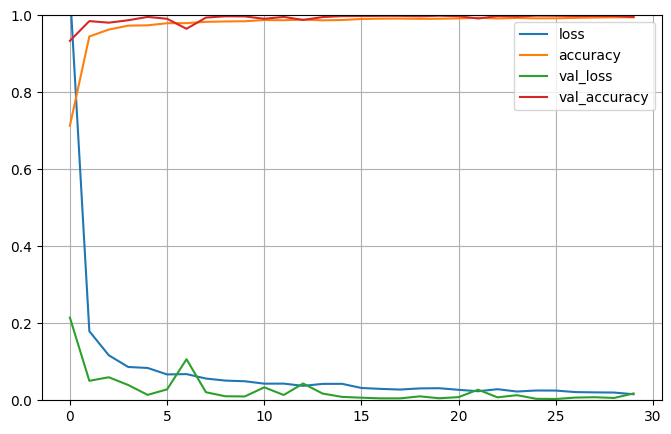

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Loading test data and running the predictions

In [25]:
test = pd.read_csv('/content/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, classes_x)*100)

395/395 [==============================] - 11s 28ms/step
Test Data accuracy:  97.12589073634204


### Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels,classes_x)

<Axes: >

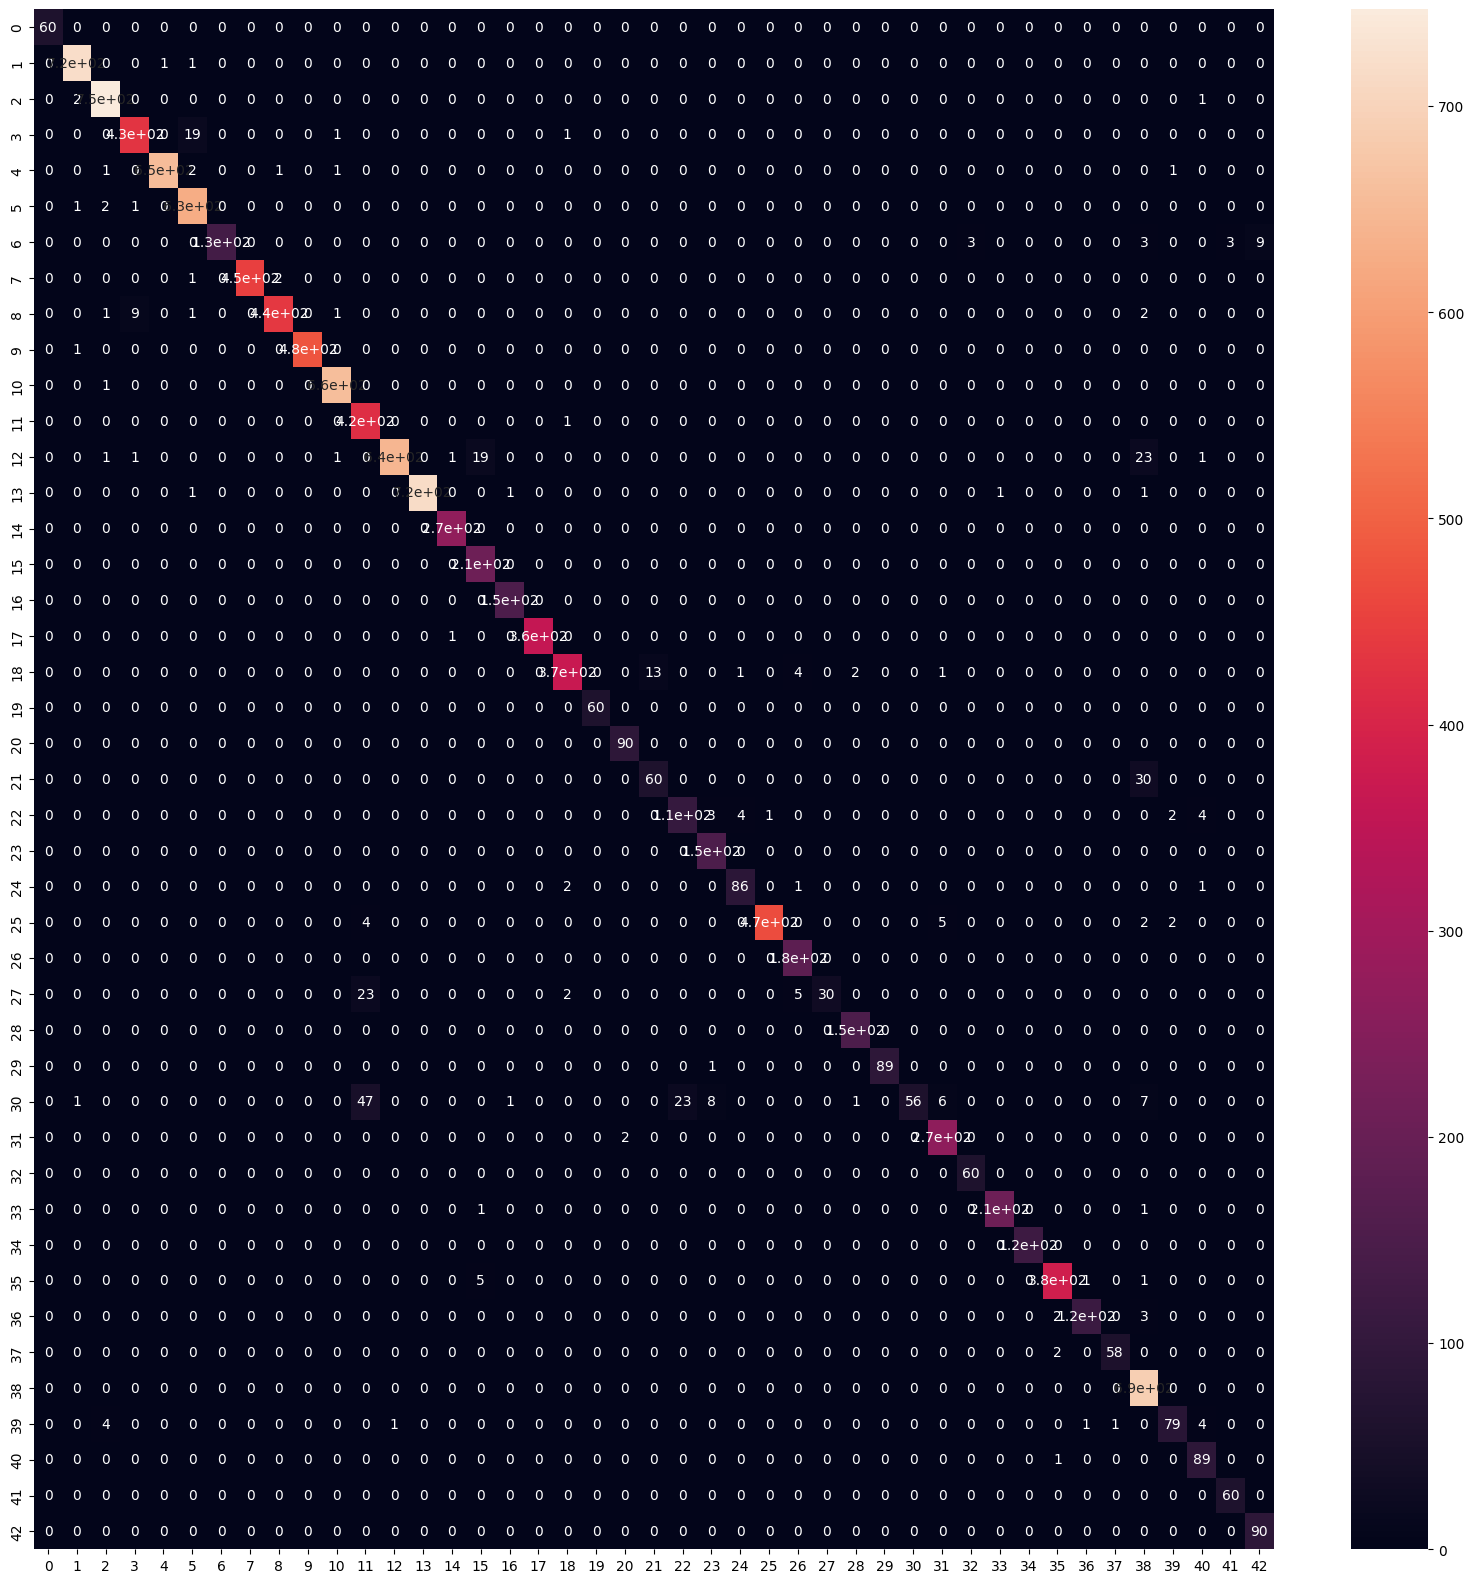

In [28]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

### Classification Report

In [29]:
from sklearn.metrics import classification_report

print(classification_report(labels, classes_x))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.97      0.95      0.96       450
           4       1.00      0.99      0.99       660
           5       0.96      0.99      0.98       630
           6       1.00      0.88      0.94       150
           7       1.00      0.99      1.00       450
           8       0.99      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       0.99      1.00      1.00       660
          11       0.85      1.00      0.92       420
          12       1.00      0.93      0.96       690
          13       1.00      0.99      1.00       720
          14       0.99      1.00      1.00       270
          15       0.89      1.00      0.94       210
          16       0.99      1.00      0.99       150
          17       1.00    

### Predictions on test data

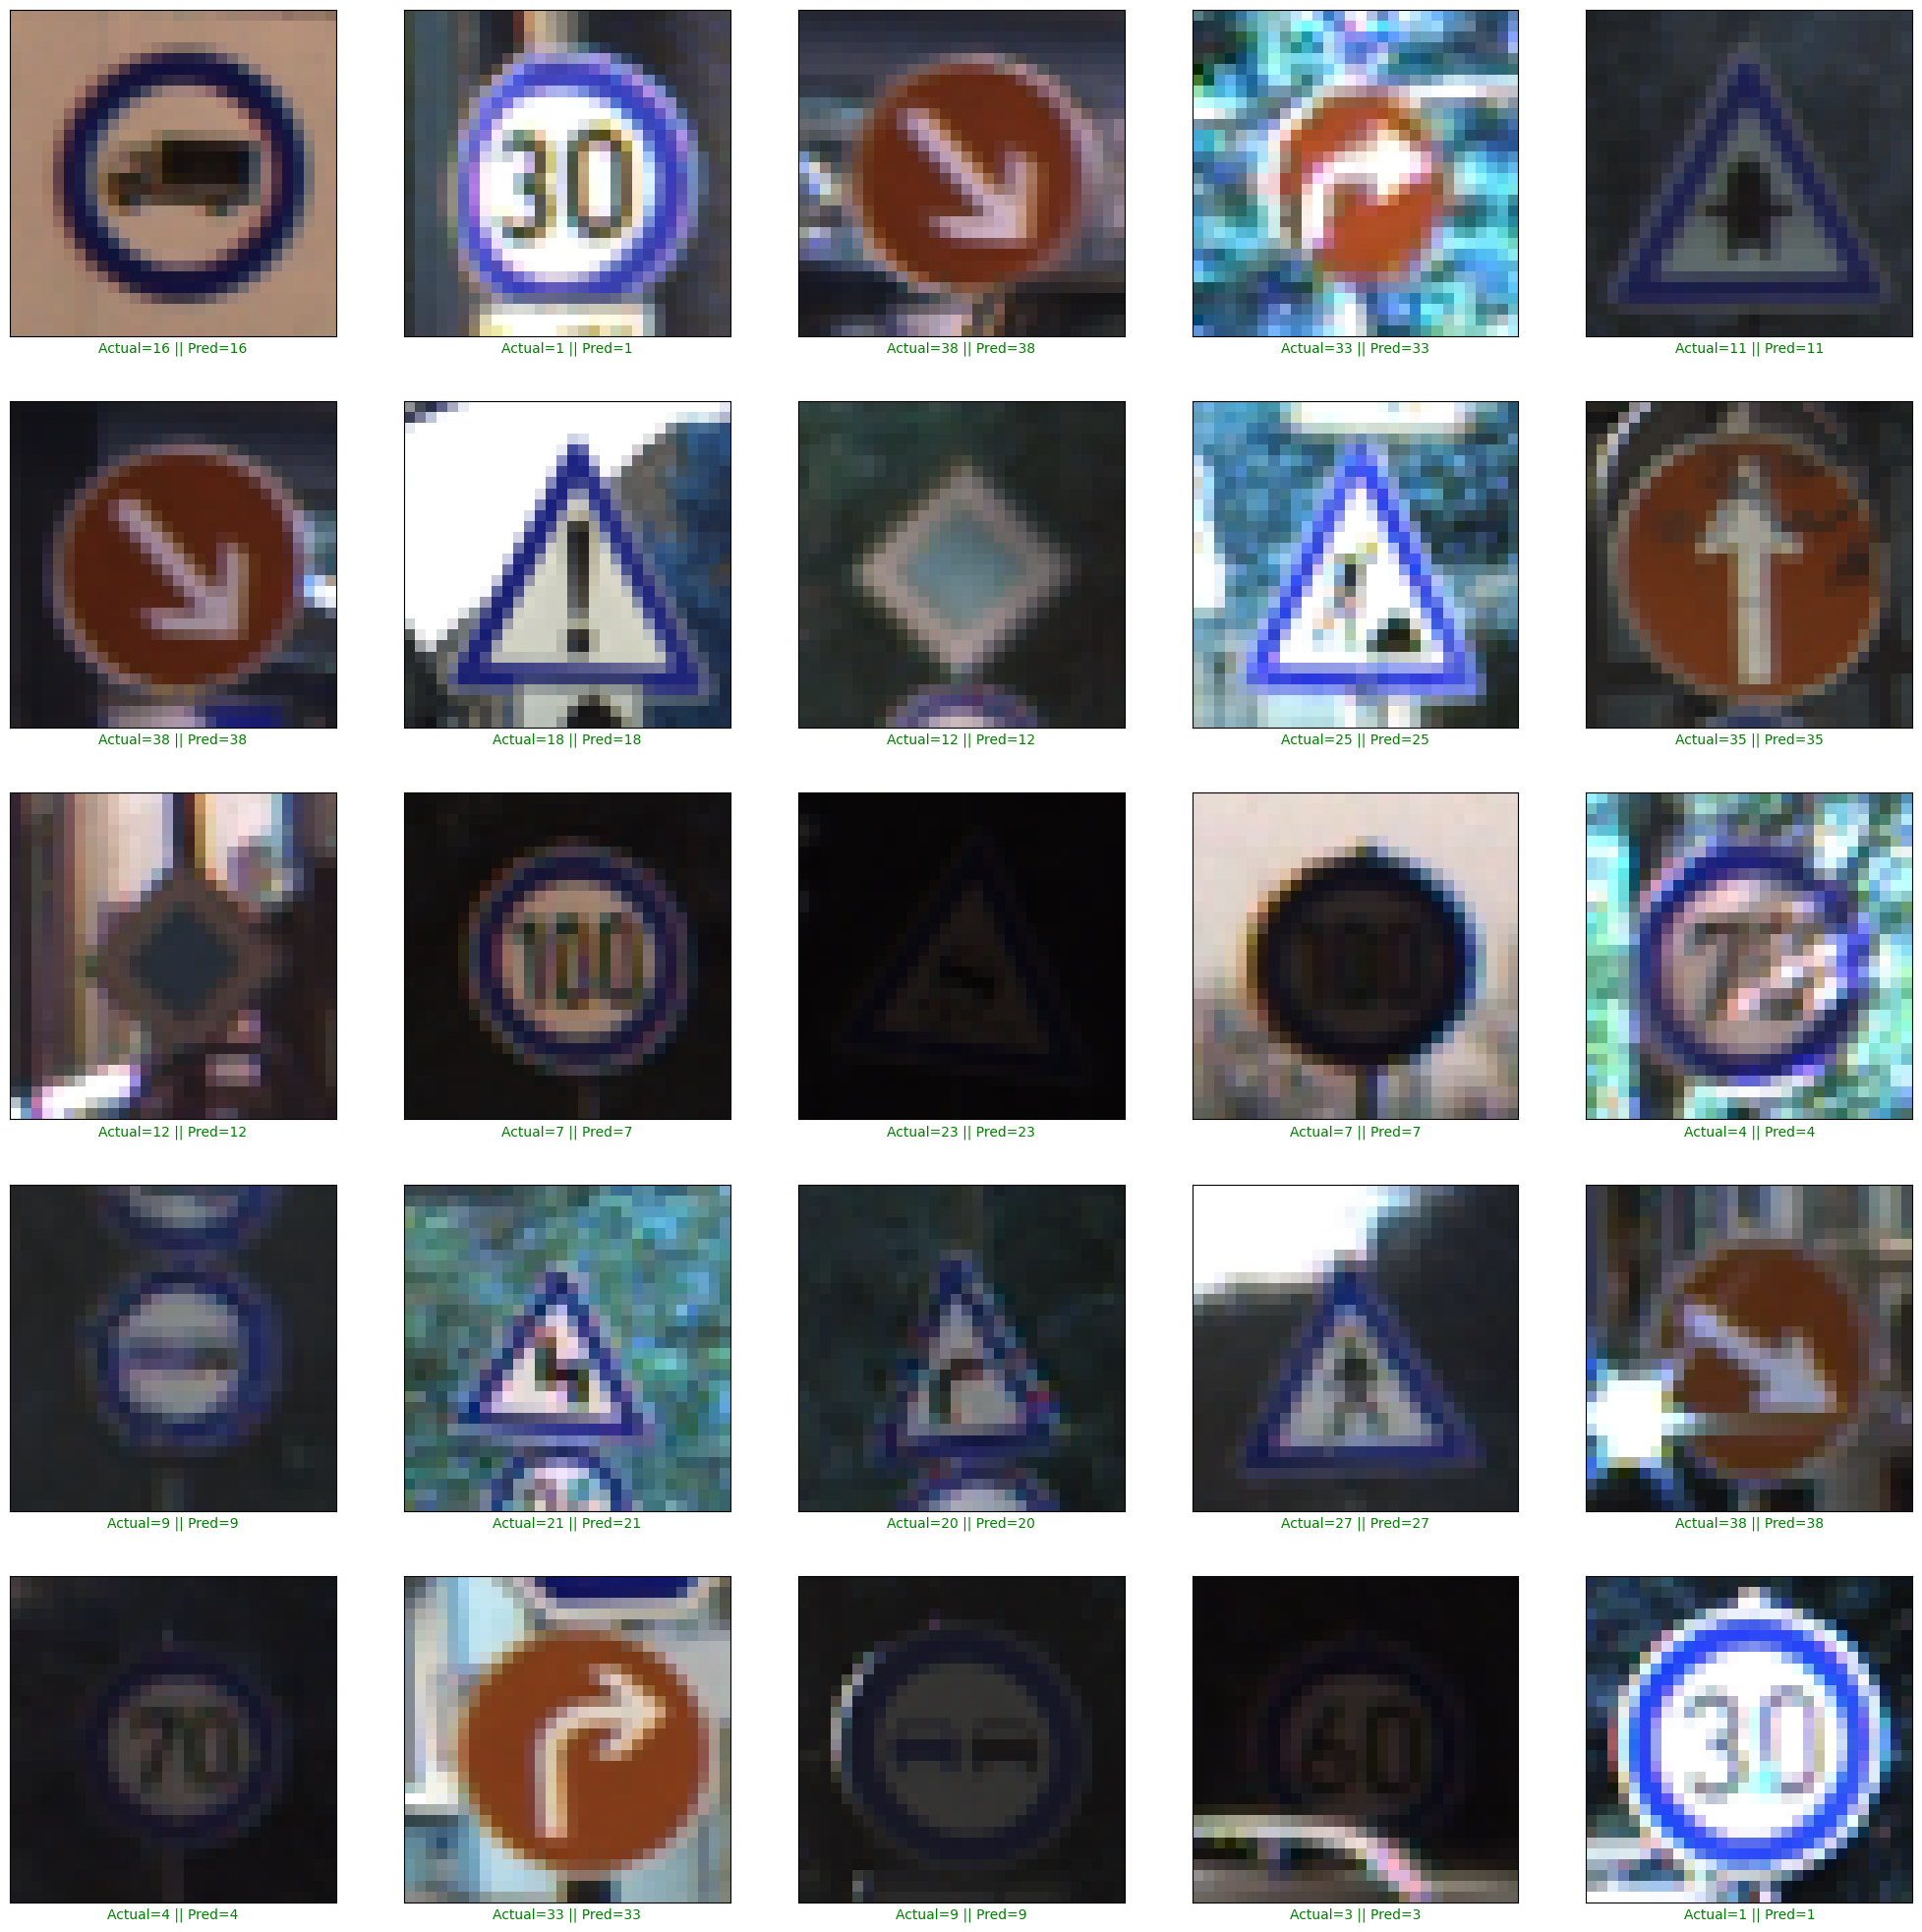

In [30]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes_x[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()